# 1. Flats above average


## 1.1 Conditional probability approach
What's the probability a flat has a price given it's features?

There is still to few data to compute $\int\, dprice\_sqm price\_smq\, P(price\_sqm|Arr,Meuble,sqm)$, so I use the simpler conditional probabilities $P(Arr,Meuble)$ or $P(Arr,sqm)$ that need less classes.


In [1]:
import qgrid
import pandas as pd
df = pd.read_pickle('data/lbc_pandas.pkl')


In [2]:
df['Arr_Meu_cls']=0
df['Arr_Sqm_cls']=0
def average_flat(to):
    def f(group):
        mean_price = group.price_sqm.median()
        group[to] [group.price_sqm>mean_price]=1
    #     group.Arr_meu_cls = group.price_sqm>mean_price.astype(int)
        return group
    return f



df = df.groupby(('Arrondissement','Meuble')).apply(average_flat('Arr_Meu_cls'))
df = df.groupby(('Arrondissement','sqm_bin')).apply(average_flat('Arr_Sqm_cls'))
careof = ['LoyerMensuel','Surface','price_sqm','Arrondissement','Meuble','ClasseEnergie_lit','url']
qgrid.show_grid(df[df.Arr_Meu_cls>0][careof])
    

## 1.2 Regression Tree approach

In [36]:
%pylab inline
import numpy as np
import seaborn as sns
sns.set_context('paper')
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

Populating the interactive namespace from numpy and matplotlib


/home/astyonax/.anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['grid']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [72]:
# prepare the grid search
rmr_params={'n_estimators':[10,50,100],
            'max_features':range(1,2),
            'min_samples_split':[2,4,8,10]}
grid = GridSearchCV(RandomForestRegressor(oob_score=True),cv=3,param_grid=rmr_params)

# prepare the dataset
careof = ['Surface','price_sqm','Arrondissement','Meuble_int','weekday','ins_hour','Ges_int','ClasseEnergie_int']
careof_rmr = ['Surface','Arrondissement']
# careof_rmr = ['Surface','Arrondissement','Meuble_int','ins_hour']
ylbl   = ['LoyerMensuel',]
z = df[careof+ylbl].dropna()
x = z[careof_rmr]
y = z[ylbl[0]]
_=grid.fit(x,y);

In [73]:
rmr = grid.best_estimator_
print grid.best_params_
print grid.best_score_

{'max_features': 1, 'min_samples_split': 10, 'n_estimators': 50}
0.406121345873


In [74]:
print cross_val_score(rmr,x,y).mean()
# rmr.fit(x,y)
features_importance = { n:y for n,y in zip(careof_rmr,rmr.feature_importances_)}
ymax = np.sum(features_importance.values())

for k,v in features_importance.iteritems():
    print "{0:20s}| {1:5.1f}%".format(k,v/ymax*100)


0.404584435179
Arrondissement      |  34.1%
Surface             |  65.9%


In [75]:
PredictedPrice = rmr.predict(x)
MoreExpensive = z.loc[y>PredictedPrice]

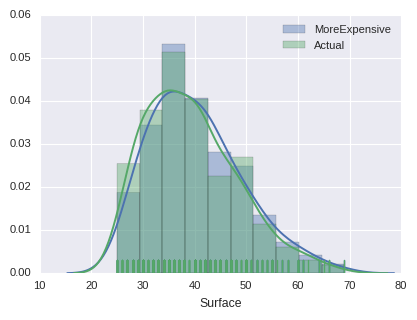

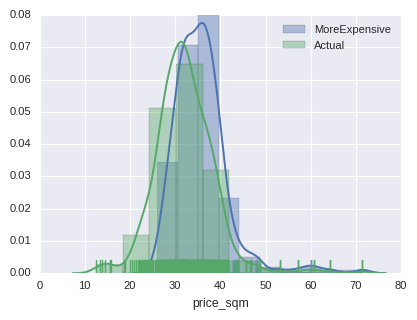

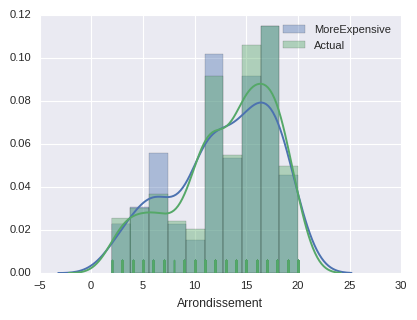

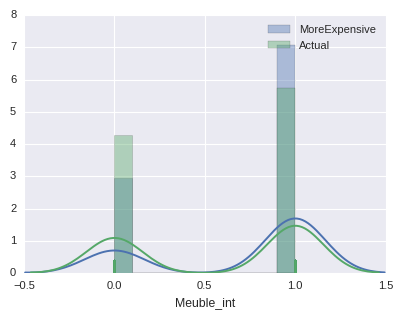

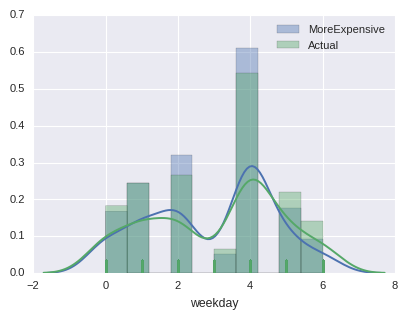

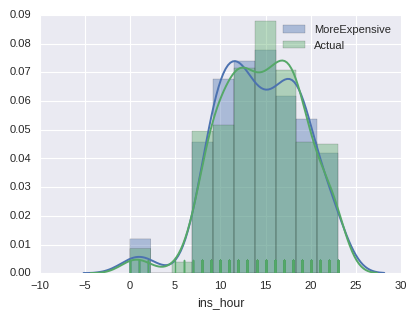

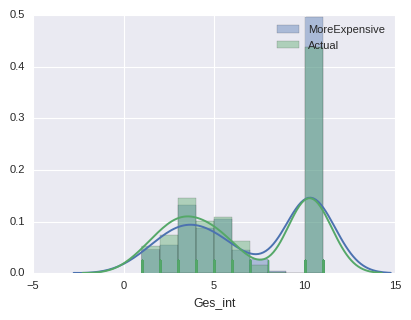

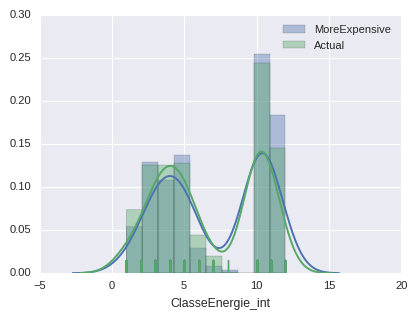

In [76]:
for feature in careof:
    sns.plt.figure(figsize=(7/1.5,5/1.5))
    sns.distplot(MoreExpensive[feature],rug=1,bins=10,label='MoreExpensive')
    sns.distplot(z[feature],rug=1,bins=10,label='Actual')
    sns.plt.legend()

In [4]:
from IPython.display import HTML
import urllib2

style=open('style.css','r').read()
HTML("""
<style>{0}</style>
""".format(style))